# Initial data exploration

In [1]:
import os
os.chdir("..")
os.getcwd()

'/Users/nathansimonis/Desktop/FinanicalBigData-EPFL-main/code'

In [2]:
import pandas as pd
import datatable as dt
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
import plotly.express as px
import pyarrow.feather as feather

plt.style.use("seaborn-white")

Convert to feather format

In [ ]:
# import zipfile
# zf = zipfile.ZipFile('../data/raw/jane-street-market-prediction.zip') 
# df = pd.read_csv(zf.open('train.csv'))
# df.to_feather("../data/raw/train.feather")

In [3]:
# Import data.
data = feather.read_feather("../data/raw/train.feather") #Much faster
float64_cols = data.select_dtypes(include='float64').columns
mapper = {col_name: np.float32 for col_name in float64_cols}
data = data.astype(mapper, copy=False)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390491 entries, 0 to 2390490
Columns: 138 entries, date to ts_id
dtypes: float32(135), int32(3)
memory usage: 1.2 GB


In [4]:
# Define label
data["action"] = np.where(data["resp"]*data["weight"]>0, 1, 0)
# Get feature names
features = data.columns[data.columns.str.contains("feature")]

## Missing values


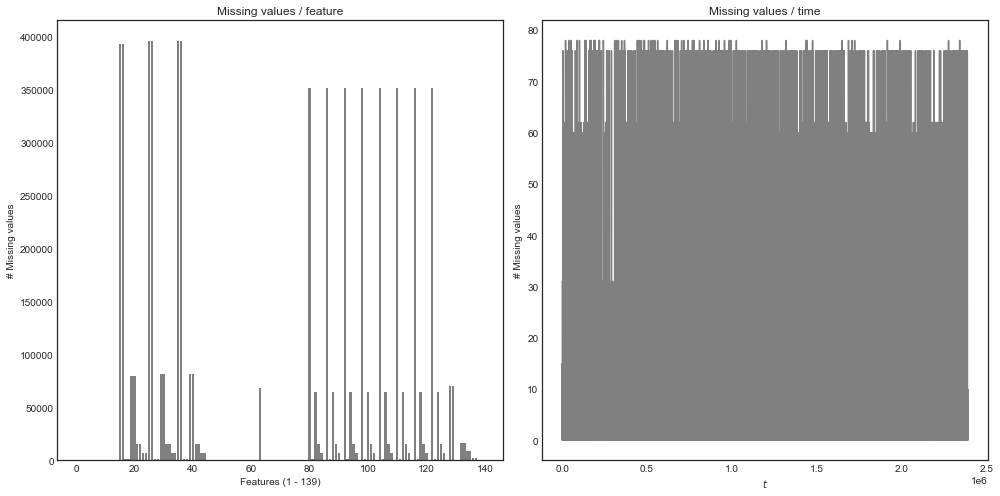

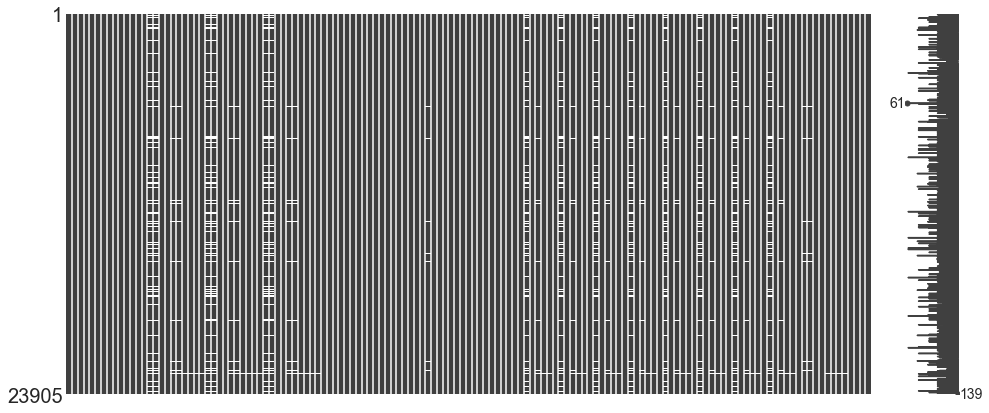

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,7))

# Missing by feature
ax1.bar(np.arange(1, data.shape[1]+1), data.isna().sum(axis=0), color = "grey")
ax1.set_xlabel(f"Features (1 - {data.shape[1]})")
ax1.set_ylabel(f"# Missing values")
ax1.set_title("Missing values / feature")

# Missing by row
ax2.plot(data.isna().sum(axis=1), c = "grey")
ax2.set_xlabel(r"$t$")
ax2.set_ylabel("# Missing values")
ax2.set_title("Missing values / time")

#plt.savefig("../figures/missing_row_cols.pdf")
plt.tight_layout()
plt.show()

# Missing matrix
msno.matrix(data[::100], figsize=(16,7))
#plt.savefig("../figures/missing_matrix.pdf")
plt.show()

#### The data does not seem to be missing at random, so it is probably not a good idea to delete lines with missing data... Alternatively, we could impute them with a mean or a median.

## Analysis of outliers

In [ ]:
import seaborn as sns

feature_cols = [c for c in train.columns if 'feature' in c]
for f in feature_cols:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
    
    sns.stripplot(y=f, data=train, size=4, color=".3", linewidth=0, ax=ax1)
    
    ax2.hist(train[f], bins=100, density=True)
    ax2.set_xlabel(f)
    ax2.set_ylabel("Density")
    
    plt.title(f)
    plt.tight_layout()
    #plt.savefig(f"../figures/{f}_hist_strip.pdf")
    plt.show()

In [6]:
normalized_df = (data[features] - data[features].mean()) / data[features].std()

In [ ]:
# Check if there is any data that is more than 4 standard deviations away from the mean.
threshold = 4
outliers_features = (normalized_df.abs() > threshold).sum()
outliers_rows = (normalized_df.abs() > threshold).sum(axis=1)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,7))

# Outliers by feature
ax1.bar(np.arange(1, normalized_df.shape[1]+1), outliers_features, color = "black")
ax1.set_xlabel(f"Features (1 - {len(features)})")
ax1.set_ylabel(f"# Outlier values")
ax1.set_title("Outlier values / feature")

# Missing by row
ax2.plot(outliers_rows, c = "black")
ax2.set_xlabel(r"$t$")
ax2.set_ylabel("# Outlier values")
ax2.set_title("Outlier values / time")

plt.tight_layout()
#plt.savefig("../figures/outlier_row_cols.pdf")
plt.show()

#### It does seems that alot of features have some outliers.  This could be a good thing identifying opportunities that are good for trading. 

## Check for very correlated variables

In [ ]:
corr = pd.DataFrame(np.corrcoef(normalized_df, rowvar=False))
sorted_corr = corr.abs().unstack().sort_values(ascending=False).drop_duplicates()
sorted_corr[1:50]

#### Seems like some features are very highly correlated. We take of this when clustering and grouping features from subclusters.